## Reproduce results in Figure 6

> **_NOTE:_**  Same datasets in Figure 5. Visualizations of figure 6b and c are in [figure 5 notebook](https://cellart.readthedocs.io/en/latest/tutorials/figure_5.html) with section named `Visualization for figure 6b,c`.

Related dataset: 
- [Xenium colorectal cancer](https://www.10xgenomics.com/cn/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard)
- [VisiumHD colorectal cancer](https://www.10xgenomics.com/cn/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard)

Reference can be download [here](11)

VisiumHD colorectal cancer are training with epoch settings: `epochs = 400` `seg_training_epochs = 15` `deconv_warmup_epochs = 200` and Xenium coloretal cancer are training with epochs settings: `epochs = 200` `seg_training_epochs = 10` `deconv_warmup_epochs = 100`

All the data for reproducing the result can be downloaded [here](temp_link)

### Characterization of TAMs

In [1]:
import pandas as pd
from scipy.sparse import coo_matrix
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
adata_svt = sc.read_h5ad("/import/home2/yhchenmath/Code/SVTBenchmarking/figure_refined/adata_svt.h5ad")
adata_svt.obsm["spatial"] = adata_svt.obs[["x", "y"]].values

In [3]:
import pandas as pd
from scipy.sparse import coo_matrix
import squidpy as sq

adata = adata_svt.copy()
sq.gr.spatial_neighbors(adata, n_neighs = 100)
sparse_matrix = adata.obsp["spatial_distances"].tocoo()

# Create DataFrame from COO matrix
df_dist = pd.DataFrame({
    "value": sparse_matrix.data,
    "x": sparse_matrix.col,
    "y": sparse_matrix.row
})
df_dist.columns = ["distance", "cell_1_index", "cell_2_index"]

distance_threshold = 100

celltypes = adata.obs["celltype"]

df_dist["cell_1_type"] = celltypes.iloc[df_dist["cell_1_index"]].values
df_dist["cell_2_type"] = celltypes.iloc[df_dist["cell_2_index"]].values

df_close = df_dist[df_dist["distance"] < distance_threshold]

mac_near_tumor = df_close[
    ((df_close["cell_1_type"] == "Macrophage") & (df_close["cell_2_type"].str.startswith("Tumor III"))) |
    ((df_close["cell_2_type"] == "Macrophage") & (df_close["cell_1_type"].str.startswith("Tumor III")))
]

cd4_t_near_tumor = df_close[
    ((df_close["cell_1_type"] == "CD4 T cell") & (df_close["cell_2_type"].str.startswith("Tumor III"))) |
    ((df_close["cell_2_type"] == "CD4 T cell") & (df_close["cell_1_type"].str.startswith("Tumor III")))
]

cd8_t_near_tumor = df_close[
    ((df_close["cell_1_type"] == "CD8 Cytotoxic T cell") & (df_close["cell_2_type"].str.startswith("Tumor III"))) |
    ((df_close["cell_2_type"] == "CD8 Cytotoxic T cell") & (df_close["cell_1_type"].str.startswith("Tumor III")))
]


# All index
mac_tumor_indices = pd.concat([
    mac_near_tumor["cell_1_index"],
    mac_near_tumor["cell_2_index"]
]).drop_duplicates().sort_values()

cd4_tumor_indices = pd.concat([
    cd4_t_near_tumor["cell_1_index"],
    cd4_t_near_tumor["cell_2_index"]
]).drop_duplicates().sort_values()

cd8_tumor_indices = pd.concat([
    cd8_t_near_tumor["cell_1_index"],
    cd8_t_near_tumor["cell_2_index"]
]).drop_duplicates().sort_values()


mac_tumor_cell_names = adata.obs_names[mac_tumor_indices]
# cd4_tumor_cell_names = adata.obs_names[cd4_tumor_indices]
# cd8_tumor_cell_names = adata.obs_names[cd8_tumor_indices]

print(len(mac_tumor_cell_names))

# Only select macrophage and tumor cells
adata_boundary = adata[mac_tumor_cell_names].copy()
# adata_boundary.write_h5ad("/import/home2/yhchenmath/Code/SVTBenchmarking/figure_refined/adata_lr.h5ad")

94616


In [4]:
# Select normal macrophage
adata_normal = adata[adata.obs["celltype"] == "Macrophage"].copy()
# Not in mac_tumor_cell_names
normal_cell_names = adata_normal.obs_names[~adata_normal.obs_names.isin(mac_tumor_cell_names)]
adata_normal = adata_normal[normal_cell_names].copy()

# Select all the tumor cells
tumor_cell_names = adata.obs_names[adata.obs["celltype"].str.startswith("Tumor III")]
adata_tumor = adata[tumor_cell_names].copy()

In [5]:
import anndata

adata_tam = adata_boundary[adata_boundary.obs["celltype"] == "Macrophage"].copy()
adata_tam.obs["celltype"] = "TAM"
adata_normal.obs["celltype"] = "Normal Macrophage"
adata_tumor.obs["celltype"] = "Tumor"

adata_plot = anndata.concat([adata_tam, adata_normal, adata_tumor])
adata_others = adata[~adata.obs_names.isin(adata_plot.obs_names)].copy()
adata_whole = anndata.concat([adata_plot, adata_others])

# Save adata_whole
# adata_whole.write_h5ad("/import/home2/yhchenmath/Code/SVTPaper/figure_5/lr/adata_whole.h5ad")

In [6]:
# Plot
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def plot_specific_celltype_gene(adata, mapping_dict, x_col = "x", y_col = "y", s = 3, revert_y = False, revert_x = False, celltype_col = "celltype"):
    fig, ax = plt.subplots(1, 4, figsize=(16, 8))
    for i in range(4):
        ax[i].set_axis_off()
    gs = GridSpec(1, 4, figure=fig)

    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3])
    # fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

    plot_dict = {}

    # Mapping dict: "[ct] [gene]"
    for k in mapping_dict:
        ct, gene = k.split(" ")
        ct = ct.replace("_", " ")
        # Select those cells: celltye is ct and gene expression of gene is not zero
        temp_adata = adata[(adata.obs[celltype_col] == ct)]
        if gene != "all":
            temp_adata = temp_adata[temp_adata[:, gene].X > 0]
        else:
            pass
        plot_dict[k] = temp_adata.copy()

    
    ax1.scatter(adata.obs[y_col], adata.obs[x_col], s=s / 2, color="lightgray")

    for k in plot_dict:
        temp_adata = plot_dict[k]
        ax1.scatter(temp_adata.obs[y_col], temp_adata.obs[x_col], s=s,  alpha=0.4, edgecolor=mapping_dict[k], lw=0.8, label=k, color =mapping_dict[k])
        ax1.scatter(temp_adata.obs[y_col], temp_adata.obs[x_col], s=s,  alpha=1, edgecolor=mapping_dict[k], lw=0.8, label=k, c="none")
    ax1.axis("off")
    ax1.set_xlim(adata.obs[x_col].min(), adata.obs[x_col].max())
    ax1.set_ylim(adata.obs[y_col].min(), adata.obs[y_col].max())
    if revert_x:
        ax1.invert_xaxis()
    if revert_y:
        ax1.invert_yaxis()

    # Add legend elements (example)
    legend_elements = [
        Line2D(
            [0], [0],
            marker='o',
            linestyle='None',
            color='w',
            label=label.replace("_", " ").replace(" all", ""),
            markerfacecolor=color,
            markeredgecolor='k',
            markersize=8
        ) for label, color in mapping_dict.items()
    ]

    # Add the legend below the entire figure, centered horizontally with [0, 1] subfigures
    ax2.legend(
        handles=legend_elements,
        loc='center',                    # Center the legend within the bounding box
        bbox_to_anchor=(0.48, 0.45),       # Center of ax2 (0.5, 0.5 is the middle of the axis)
        ncol=2,                          # Number of columns for the legend
        handletextpad=0.35,               # Spacing between marker and text
        columnspacing=1,               # Spacing between legend columns
        prop={'size': 12, 'style': 'italic'},  # Font size and style
        frameon=False                    # No border for the legend
    )

    ax2.axis("off")  # Hide the axis for ax2
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.15, 1, 1])  # Leave space for the legend below the plots
    plt.show()

    return plot_dict

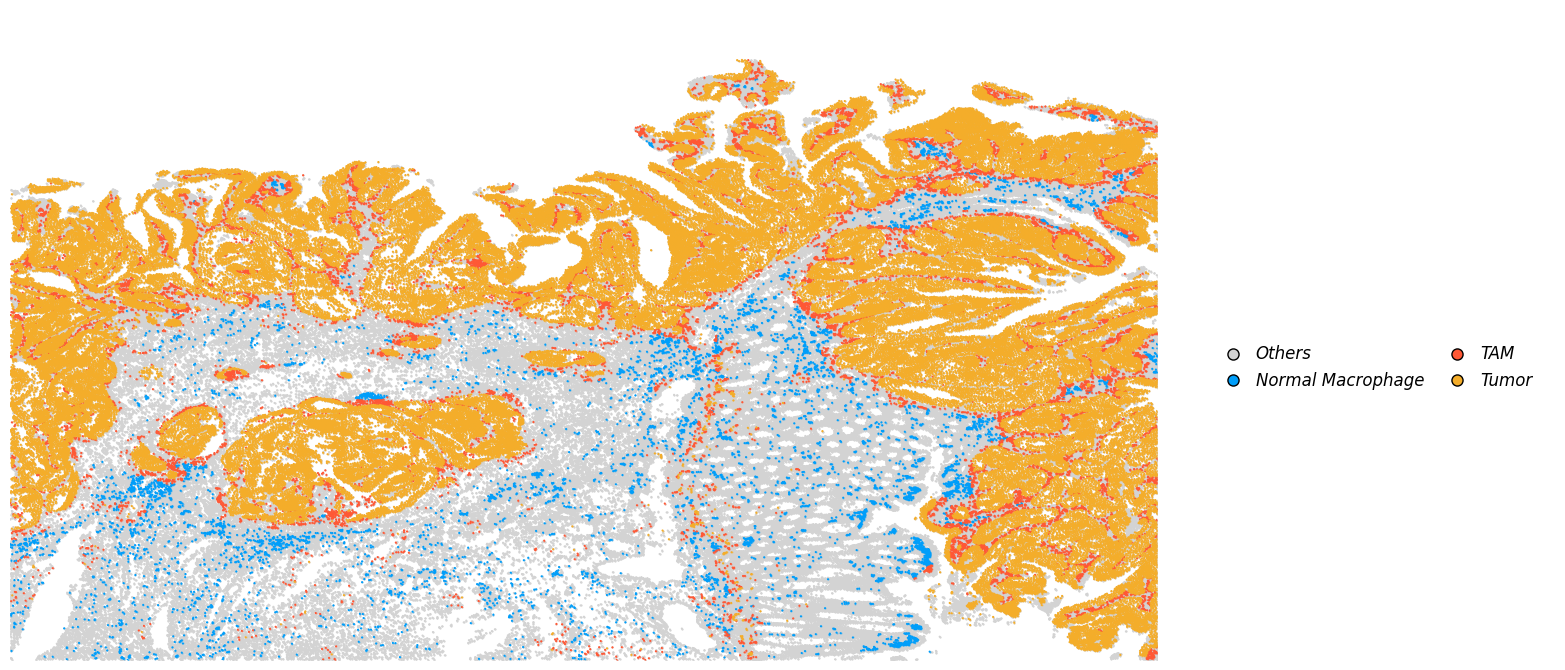

In [7]:
mapping_dict = {
    "Others all": "lightgray",
    "Normal_Macrophage all": "#009EFA",
    "TAM all": "#FF5835",
    "Tumor all": "#F4AD2A",

}
adata_others_temp = adata_others.copy()
adata_others_temp.obs["celltype"] = "Others"
adata_combined = anndata.concat([adata_plot, adata_others_temp])
_ = plot_specific_celltype_gene(adata_combined, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

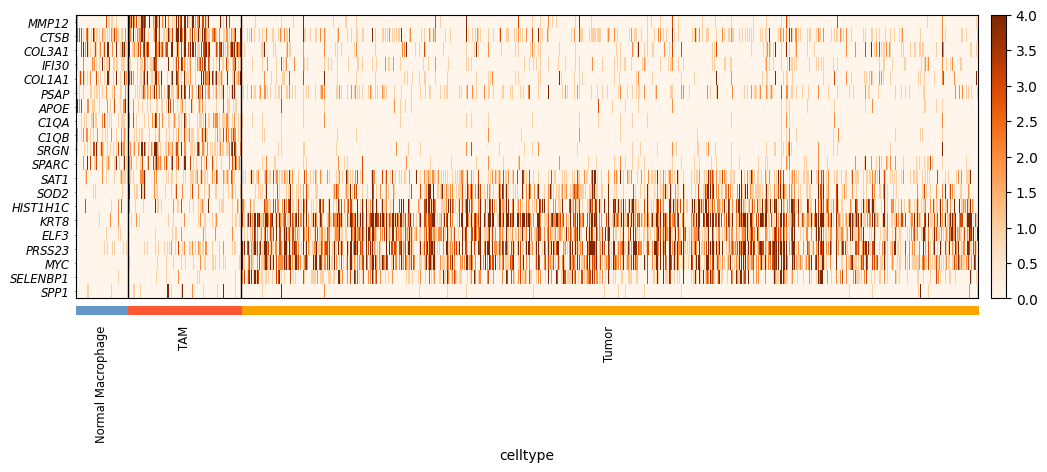

In [8]:
selected_gene = [
    "MMP12","CTSB", "COL3A1", "IFI30", "COL1A1", "PSAP", "APOE", "C1QA",  "C1QB", "SRGN", "SPARC"
    ,"SAT1", "SOD2", "HIST1H1C", "KRT8", "ELF3", "PRSS23", "MYC", "SELENBP1", "SPP1"
]

gene_list = selected_gene
# As type categorical
adata_plot.obs['celltype'] = adata_plot.obs['celltype'].astype('category')

adata_plot.obs['celltype'] = adata_plot.obs['celltype'].cat.reorder_categories(
    ["Normal Macrophage", "TAM", "Tumor"],
    ordered=True  # optional
)
adata_plot.uns["celltype_colors"] = ["#6297CA", "#FF5733", "#FFA500"]
# Only show invasive tumor and Prolif Invasive Tumor

hm = sc.pl.heatmap(adata_plot, gene_list, groupby='celltype', cmap='Oranges', show_gene_labels=True, vmax=4, swap_axes=True, show=False, figsize=(12,4))
ax = hm['heatmap_ax']
for l in ax.get_yticklabels():
    l.set_style("italic")

# Show with high dpi    
plt.show(block=True)

In [17]:
import scanpy as sc
from collections.abc import Iterable
from typing import Union, List
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
import math
from pathlib import Path
# from sg_utils.pl.utils import lighten_color

def format_ax(
    fig, ax,
    style="umap",
    title="",
    cbar=True,
    dim_label="UMAP",
    fs=12,
    lw=1.5,
    arrow_len=0.2,
    draw_arrows=True,
):
    ax.set_facecolor('white')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.grid(False)
    ax.spines[list(ax.spines)].set_visible(False)

    if style == "umap":
        change_aspect(ax)
        if draw_arrows:
            arrowed_spines(ax, arrow_len, text=dim_label, fs=fs, lw=lw)
        ax.set_title(title, weight="bold")
    if cbar:
        format_cbar(fig, ax)


def format_cbar(fig, ax):

    cbar = ax.get_children()[0].colorbar
    if cbar:
        cbar.remove()
    data = ax.get_children()[0]

    # Create colorbar ax
    bbox = ax.get_position()
    cax = fig.add_axes([
        bbox.x1+bbox.width*0.025, #min x
        bbox.y0+bbox.height*0.25, #min y
        bbox.width*0.03, #width
        bbox.height*0.5 #height
    ])
    cax.grid(False)
    new_cbar = fig.colorbar(
        data, ax=ax, cax=cax,
    )
    new_cbar.outline.set_visible(False)
    if not cbar:
        bbox = ax.get_position()
        ax.get_children()[0].colorbar.remove()
        ax.set_position(bbox)


def change_aspect(ax):

    # Reset x and y limits for square plotting
    xmin, xmax = ax.get_xlim()
    xrange = xmax - xmin
    xcenter = (xrange/2) + xmin

    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ycenter = (yrange/2) + ymin

    axrange = max(xrange, yrange)/2

    xmin = xcenter - (axrange)
    xmax = xcenter + (axrange)
    ax.set_xlim(xmin, xmax)

    ymin = ycenter - (axrange)
    ymax = ycenter + (axrange)
    ax.set_ylim(ymin, ymax)

    ax.set_aspect('equal', adjustable = 'box')


def arrowed_spines(
    ax,
    length = 0.2,
    text = None,
    fs = None,
    lw = 1.5,
):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    hw = 1./30.*(ymax-ymin)
    hl = 1./30.*(xmax-xmin)
    lw = lw # axis line width
    ohg = 0.0 # arrow overhang

    ax.spines[list(ax.spines)].set_visible(False)
    ax.arrow(
        xmin, ymin, (xmax-xmin)*length, 0, fc='k', ec='k', lw = lw,
        head_width=hw, head_length=hl, overhang = ohg,
        length_includes_head= True, clip_on = False
    )
    ax.arrow(
        xmin, ymin, 0, (ymax-ymin)*length, fc='k', ec='k', lw = lw,
        head_width=hw, head_length=hl, overhang = ohg,
        length_includes_head= True, clip_on = False
    )
    if fs == None:
        fs = plt.rcParams["xtick.labelsize"]
    ax.text(
        s=f"{text}1",
        y=ymin-(ymax-ymin)*0.05, x=xmin+(xmax-xmin)*length/2,
        ha="center", va="top",
        fontsize = fs
    )
    ax.text(
        s=f"{text}2",
        x=xmin-(xmax-xmin)*0.05, y=ymin+(ymax-ymin)*length/2,
        ha="right", va="center", rotation=90,
        fontsize = fs
    )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


def plot_embedding(
    adata: sc.AnnData,
    features: Union[str, List[str]],
    basis: str = 'X_umap',
    palette: str = "tab20",
    cmap: str = "plasma",
    titles: Union[str, List[str]] = None,
    ncols: int = 5,
    dim: int = 5,
    layer: str = "imputed",
    dim_label = "UMAP",
    ax = None,
    fs: int = 12,
    lw: float = 1.5,
    arrow_len: float = 0.2,
    draw_arrows=False,
    rasterized=False,
    cbar=True,
    **kwargs,
):
    iterify = lambda x: x if isinstance(x, Iterable) and not isinstance(x, str) else [x]
    features = iterify(features)
    titles = iterify(titles)
    if not ax:
        nrows = math.ceil(len(features))
        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(dim*ncols,dim*nrows),
        )
        fig.tight_layout(pad=dim*0.75)
        axes = axes.flat if isinstance(axes, Iterable) else [axes]
    else:
        assert (len(features)==1) and (len(titles)==1)
        fig = ax.get_figure()
        axes = [ax]
    for ax, feature, title in itertools.zip_longest(axes, features, titles):
        if not title: title = feature
        if feature:
            sc.pl.embedding(
                adata,
                basis=basis,
                color=feature,
                ax=ax,
                show=False,
                palette=palette, cmap=cmap,
                layer=layer,
                colorbar_loc=None,
                **kwargs,
            )
            if rasterized:
                ax.get_children()[0].set_rasterized(True)
            format_ax(
                fig, ax, style="umap",
                title=title, dim_label=dim_label, fs=fs,
                arrow_len=arrow_len, lw=lw, draw_arrows=draw_arrows,
            )
        else:
            ax.set_visible(False)
    return fig


def saturate(c, s=1.0):
    from matplotlib import colors
    from collections.abc import Iterable
    # Assumed to be hex if string
    if isinstance(c, str):
        rgb = colors.to_rgb(c)
        hex = True
    # Assumed to be RGB if iterable
    elif isinstance(c, Iterable):
        rgb = c
        hex = False
    hsv = colors.rgb_to_hsv(rgb)
    hsv[1] *= s
    c = colors.hsv_to_rgb(hsv)
    if hex:
        return colors.to_hex(c)
    else:
        return c

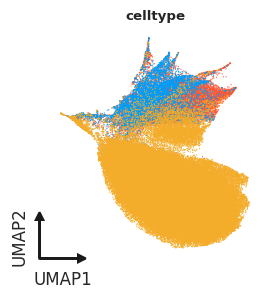

In [26]:
ad_st = adata_plot.copy()
# Filtered min counts
sc.pp.filter_genes(ad_st, min_counts=20)

sc.pp.pca(ad_st)
sc.pp.neighbors(ad_st)

sc.tl.umap(ad_st, min_dist=0.3)

celltype_mapping = {
    "Normal Macrophage": "#009EFA",
    "TAM": "#FF5835",
    "Tumor": "#F4AD2A",

}
fig, ax = plt.subplots(1, 1, figsize = (3,3))
_ = plot_embedding(
    ad_st,
    features='celltype',
    basis="X_umap",
    palette=celltype_mapping,
    ax=ax,
    dim_label="UMAP",
    fs=12,
    lw=1.5,
    arrow_len=0.2,
    draw_arrows=True,
    # Other
    legend_loc = "none",
    size = 3
)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
# selected_gene = "COL3A1" # Tumor+, Boundary +

# selected_gene = "PSAP" # Boundary +, HD Only

# Set color mapping
palette = {
    "Tumor": "#F4AD2A",
    "Normal Macrophage": "#76A3D0",      # white violin (no fill)
    "TAM": "#FF5835"
}

/tmp/ipykernel_1057144/3781531446.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/tmp/ipykernel_1057144/3781531446.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
/tmp/ipykernel_1057144/3781531446.py:11: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.3`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.



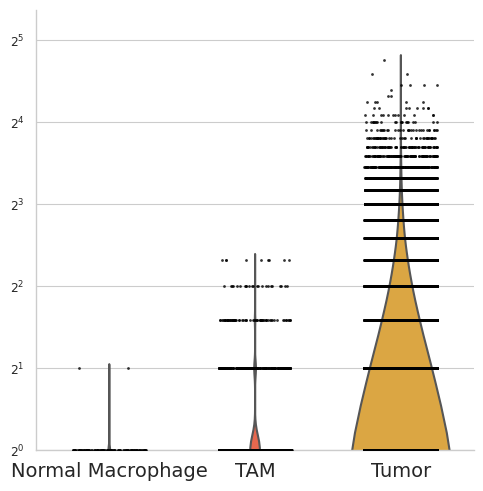

In [35]:
selected_gene = "MYC"

df = pd.DataFrame({
    "group": adata_plot.obs["celltype"].astype(str),
    "value": adata_plot[:, selected_gene].X.flatten()
})

plot_order = ["Normal Macrophage", "TAM", "Tumor"]
# Plot
plt.figure(figsize=(5, 5))
ax = sns.violinplot(
    x="group",
    y="value",
    data=df,
    order=plot_order,
    scale="width",
    inner=None,
    linewidth=1.5,
    palette=palette,
    bw=0.3
)

# Overlay dot strip
sns.stripplot(
    x="group",
    y="value",
    order=plot_order,
    data=df,
    color="black",
    size=2,
    jitter=0.25,
    alpha=0.8
)

# Log scale y-axis
ax.set_yscale("log", base=2)
ax.set_ylim(bottom=1)  # Set y-axis limits to avoid log scale issues
# ax.set_yticks([1, 3, 10, 30])
# ax.set_yticklabels(["1", "3", "10", "30"], fontsize=12)


# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("")

# Bold gene label title
plt.title("")

plt.tight_layout()
plt.show()

/tmp/ipykernel_1057144/639527426.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/tmp/ipykernel_1057144/639527426.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
/tmp/ipykernel_1057144/639527426.py:11: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.3`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.



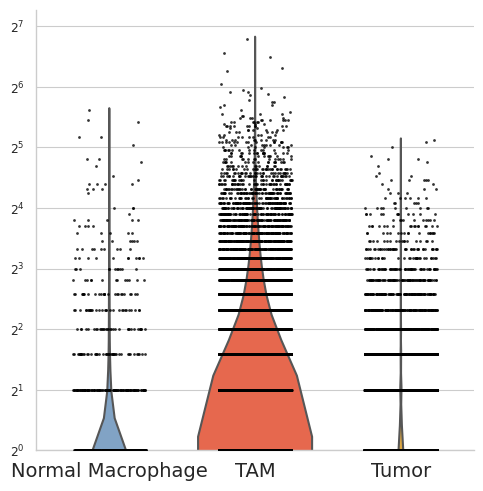

In [36]:
selected_gene = "MMP12"

df = pd.DataFrame({
    "group": adata_plot.obs["celltype"].astype(str),
    "value": adata_plot[:, selected_gene].X.flatten()
})

plot_order = ["Normal Macrophage", "TAM", "Tumor"]
# Plot
plt.figure(figsize=(5, 5))
ax = sns.violinplot(
    x="group",
    y="value",
    data=df,
    order=plot_order,
    scale="width",
    inner=None,
    linewidth=1.5,
    palette=palette,
    bw=0.3
)

# Overlay dot strip
sns.stripplot(
    x="group",
    y="value",
    order=plot_order,
    data=df,
    color="black",
    size=2,
    jitter=0.25,
    alpha=0.8
)

# Log scale y-axis
ax.set_yscale("log", base=2)
ax.set_ylim(bottom=1)  # Set y-axis limits to avoid log scale issues
# ax.set_yticks([1, 3, 10, 30])
# ax.set_yticklabels(["1", "3", "10", "30"], fontsize=12)


# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("")

# Bold gene label title
plt.title("")

plt.tight_layout()
plt.show()

/tmp/ipykernel_1057144/1361498247.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/tmp/ipykernel_1057144/1361498247.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
/tmp/ipykernel_1057144/1361498247.py:11: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.3`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.



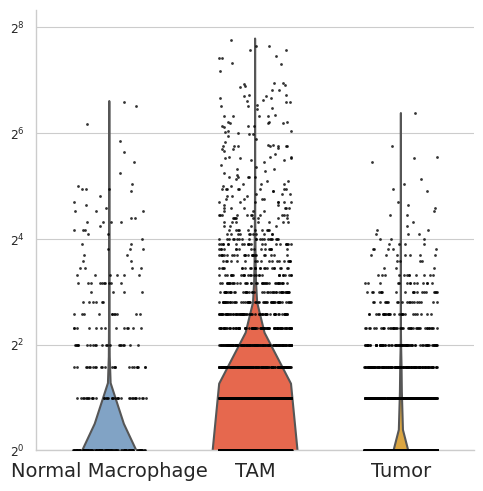

In [37]:
selected_gene = "SPP1"

df = pd.DataFrame({
    "group": adata_plot.obs["celltype"].astype(str),
    "value": adata_plot[:, selected_gene].X.flatten()
})

plot_order = ["Normal Macrophage", "TAM", "Tumor"]
# Plot
plt.figure(figsize=(5, 5))
ax = sns.violinplot(
    x="group",
    y="value",
    data=df,
    order=plot_order,
    scale="width",
    inner=None,
    linewidth=1.5,
    palette=palette,
    bw=0.3
)

# Overlay dot strip
sns.stripplot(
    x="group",
    y="value",
    order=plot_order,
    data=df,
    color="black",
    size=2,
    jitter=0.25,
    alpha=0.8
)

# Log scale y-axis
ax.set_yscale("log", base=2)
ax.set_ylim(bottom=1)  # Set y-axis limits to avoid log scale issues
# ax.set_yticks([1, 3, 10, 30])
# ax.set_yticklabels(["1", "3", "10", "30"], fontsize=12)


# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("")

# Bold gene label title
plt.title("")

plt.tight_layout()
plt.show()

### Legend receptor

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmasher as cmr

def lr_heatmap_mag_target(lr_res, sources, target, filter_thres1s, filter_thres2s, n_top_orders, 
                          source_names=None, target_name=None,
                          add_lrs=None, cmap_lr=None, leg_bbox=None, mx=None, my=None, rot_x=90):
    
    order_metric = 'magnitude_rank'
    filter_metric1 = 'magnitude_rank'
    filter_metric2 = 'magnitude_rank'

    keep_cols = ['lr', 'source', 'target', 'magnitude_rank']
    dfs = []
    for i, source in enumerate(sources):
        df = lr_res.loc[(lr_res.source==source)&(lr_res.target==target)]
        df0 = df.loc[(df[filter_metric1]<=filter_thres1s[i])&(df[filter_metric2]<=filter_thres2s[i])]
        df_ = df0[keep_cols].sort_values(order_metric).head(n_top_orders[i])
        lrs_ = df_.lr.values.tolist()
        df_ = lr_res.loc[(lr_res.lr.isin(lrs_))&(lr_res.source.isin(sources))&(lr_res.target==target)][keep_cols]
        print(source, len(lrs_), df_.shape)
        if add_lrs is not None:
            for lr in add_lrs:
                if lr not in df_.lr.values:
                    if lr in df.lr.values:
                        df_ = pd.concat([df_, df.loc[df.lr==lr][keep_cols]])
                    else:
                        df_ = pd.concat([df_, pd.DataFrame([[lr, source, target, 1, 1]], columns=keep_cols)])
        df_ = df_.sort_values(order_metric)
        dfs.append(df_)
    concat_df = pd.concat(dfs).drop_duplicates()
    print(len(concat_df), concat_df.lr.unique().shape)

    spec_long = concat_df[['lr', 'source', 'magnitude_rank']]
    spec_wide = spec_long.pivot(index='lr', columns='source', values='magnitude_rank').fillna(1)
    spec_wide['min'] = spec_wide.min(1)
    spec_wide = spec_wide.sort_values('min')
    spec_wide = spec_wide.iloc[:,:len(sources)]
    mag_long = concat_df[['lr', 'source', 'magnitude_rank']]
    mag_wide = mag_long.pivot(index='lr', columns='source', values='magnitude_rank').fillna(1)
    mag_wide['min'] = mag_wide.min(1)
    mag_wide = mag_wide.sort_values('min')
    mag_wide = mag_wide.iloc[:,:len(sources)]
    print('Combine:', len(mag_wide))
    mag_df = mag_wide.stack().reset_index(name='mag')
    spec_df = spec_wide.stack().reset_index(name='spec')
    mag_spec_df = mag_df.merge(spec_df, on=['lr', 'source'])
    mag_spec_df['mag'] = -np.log10(mag_spec_df['mag'].values)
    mag_spec_df['spec'] = -np.log10(mag_spec_df['spec'].values)
    mag_spec_df['source'] = pd.Categorical(mag_spec_df['source'], categories=sources)


    ## heatmap
    plt.rcParams.update({"figure.dpi": 100})
    sns.set_theme(style="whitegrid")
    sns.set_context('paper',font_scale=1.)
    # cmap_lr = cmr.get_sub_cmap(mpl.cm.magma, 0.05,0.95)
    if cmap_lr is None:
        cmap_lr = cmr.get_sub_cmap(sns.cubehelix_palette(rot=0.1, dark=0.2, light=0.8, as_cmap=True, reverse=True), 0, 1)

    if source_names is None:
        source_names = sources
    xticklabels = source_names
    fs = 10
    w = 3
    h = 0.3 * len(mag_wide)
    if mx is None or my is None:
        mx = 0.5/(len(sources)-1) if len(sources) > 1 else 5 
        my = 0.5/(len(mag_wide)-1) 
    sizes = (10, 250)
    hue_max = mag_spec_df['spec'].max()
    size_max = mag_spec_df['mag'].max()
    g = sns.relplot(
        data=mag_spec_df, 
        x="source", y="lr", hue="spec", size="mag",
        palette=cmap_lr, hue_norm=(0,hue_max), size_norm=(0,size_max), edgecolor=".7",
        height=h, aspect=1, sizes=sizes, legend=True, 
    )
    if target_name is None:
        target_name = target
    title = f'$\\rightarrow$ {target_name}'
    g.set(xlabel="", ylabel="", xticklabels=xticklabels, title=None, aspect='equal')
    g._axes[0][0].set_title(title, fontsize=fs+2, color='darkblue')
    g.set_xticklabels(size = fs, rotation=rot_x)
    g.set_yticklabels(size = fs, style='italic')
    g.despine(left=True, bottom=True)
    g.ax.margins(x=mx, y=my)
    if leg_bbox is not None:
        for i in range(len(g._legend.texts)):
            if g._legend.texts[i].get_text() == 'spec':
                g._legend.texts[i].set_text('Spec.')
            if g._legend.texts[i].get_text() == 'mag':
                g._legend.texts[i].set_text('Mag.')
        sns.move_legend(
            g, "center", bbox_to_anchor=leg_bbox, fontsize=fs, ncols=1, frameon=False, alignment='left',
        )
    else:
        g._legend.remove()
    
    return concat_df


import liana as li


adata = adata_boundary.copy()

In [10]:
expr_prop = 0.05
lrTAM = li.mt.rank_aggregate(adata,
                     groupby='celltype',
                     resource_name='consensus',
                     expr_prop=expr_prop,
                     use_raw=False,
                     verbose=True,
                     inplace=False)

Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
74 samples of mat are empty, they will be removed.
Make sure that normalized counts are passed!
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.59 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 94616 samples and 568 features


/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:360: RuntimeWarning: overflow encountered in power


Running CellPhoneDB


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 16.98it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


TAM 15 (15, 4)
15 (15,)
Combine: 15


/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/seaborn/axisgrid.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


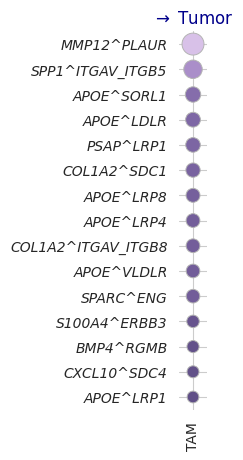

In [11]:
lrTAM['lr'] = lrTAM[['ligand_complex', 'receptor_complex']].agg('^'.join, axis=1)

# Mapping source / target names: Macrophage -> TAM, Tumor -> Tumor, CD8 Cytotoxic T cell -> CD8 T cell
lrTAM.source = lrTAM.source.replace({'Macrophage': 'TAM'})
lrTAM.target = lrTAM.target.replace({'CD8 Cytotoxic T cell': 'CD8 T cell'})
lrTAM.target = lrTAM.target.replace({'Tumor III': 'Tumor'})

# Exclude: source is TAM and lr starts with COL1A1 (cancer associated fibroblast ligands, due to diffusion)
lrTAM = lrTAM[~((lrTAM.source == 'TAM') & (lrTAM.ligand_complex.str.startswith('COL1A1')))]

temp = lr_heatmap_mag_target(lrTAM,
                      sources=['TAM'], 
                      target='Tumor',
                      filter_thres1s=[1,1], 
                      filter_thres2s=[1,1], 
                      n_top_orders=[15]*3, 
                      leg_bbox=None)

In [12]:
raw_ct = adata_svt.obs["celltype"].copy().astype(str)
# TAM index
tam_idx = adata[adata.obs["celltype"].isin(["Macrophage"])].obs_names
raw_ct[tam_idx] = "TAM"

adata_svt.obs["celltype"] = raw_ct.astype("category")

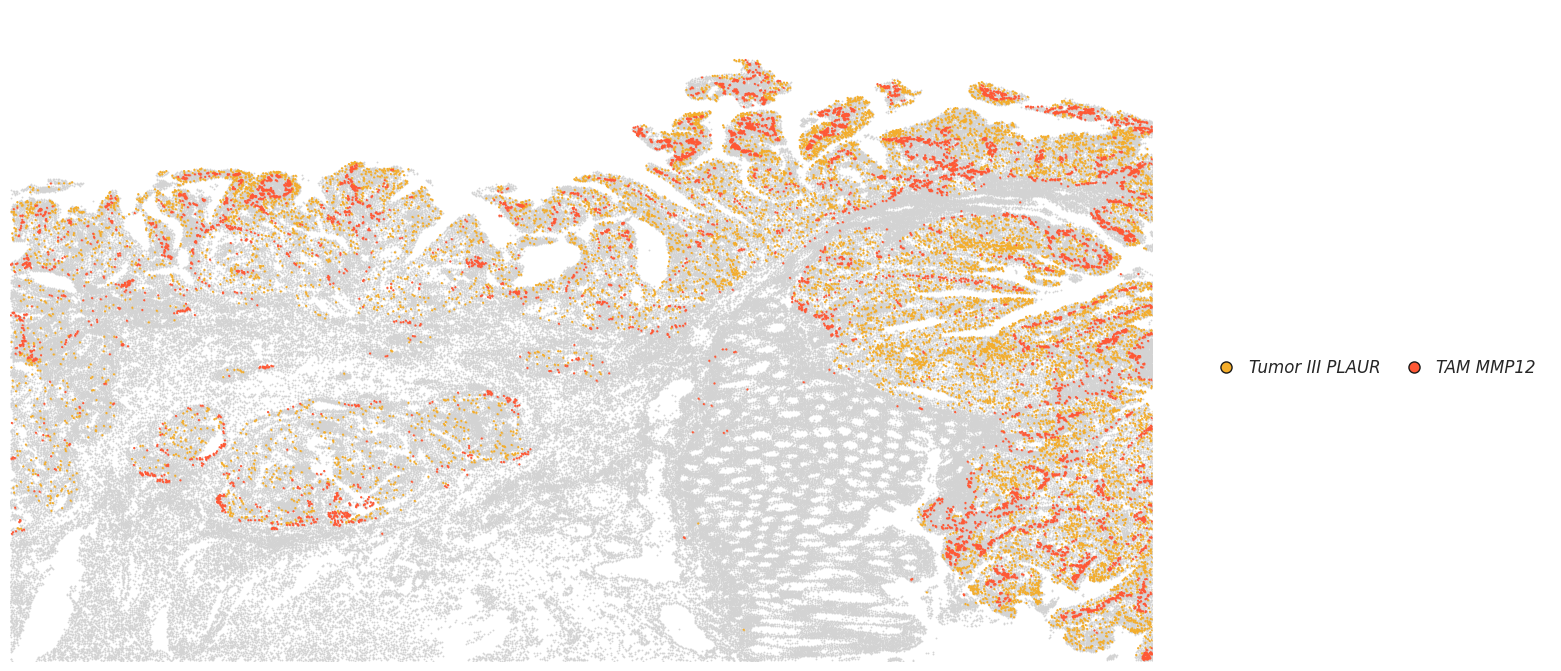

In [15]:
mapping_dict = {
    "Tumor_III PLAUR":  "#F4AD2A", # ""SDC1"
    "TAM MMP12": "#FF5835",
}

temp = plot_specific_celltype_gene(adata_svt, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

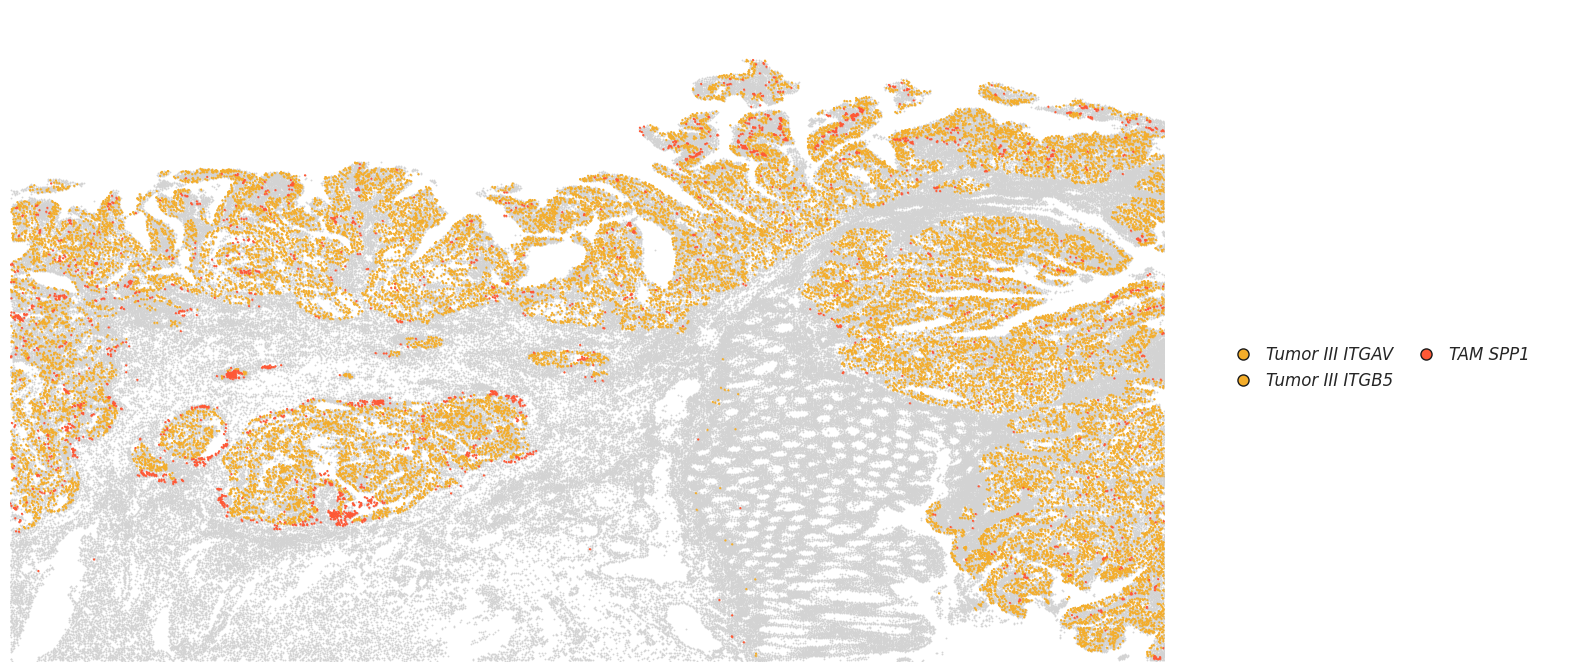

In [ ]:
mapping_dict = {
    "Tumor_III ITGAV": "#F4AD2A",
    "Tumor_III ITGB5": "#F4AD2A",
    "TAM SPP1": "#FF5835",
}

temp = plot_specific_celltype_gene(adata_svt, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

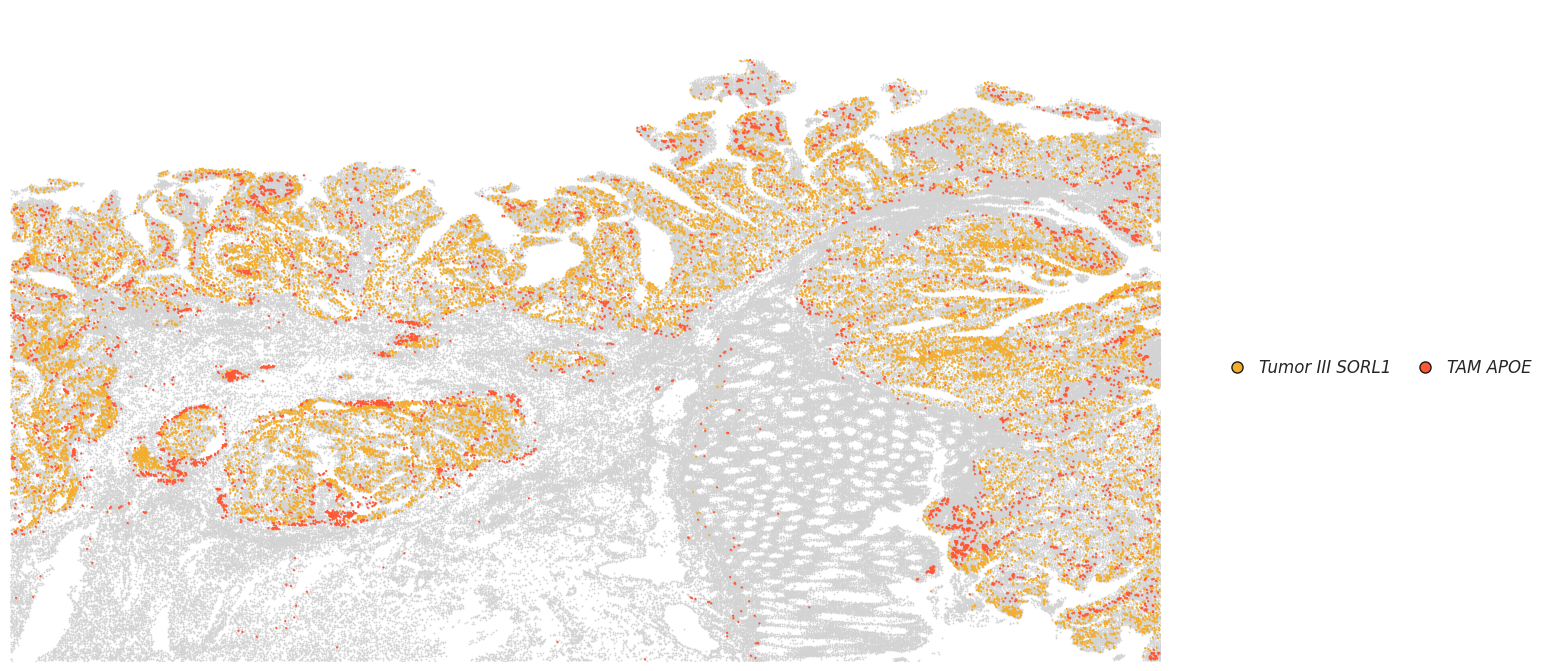

In [16]:
mapping_dict = {
    "Tumor_III SORL1": "#F4AD2A",
    "TAM APOE": "#FF5835",
}

temp = plot_specific_celltype_gene(adata_svt, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

### Visualization for figure 5 g

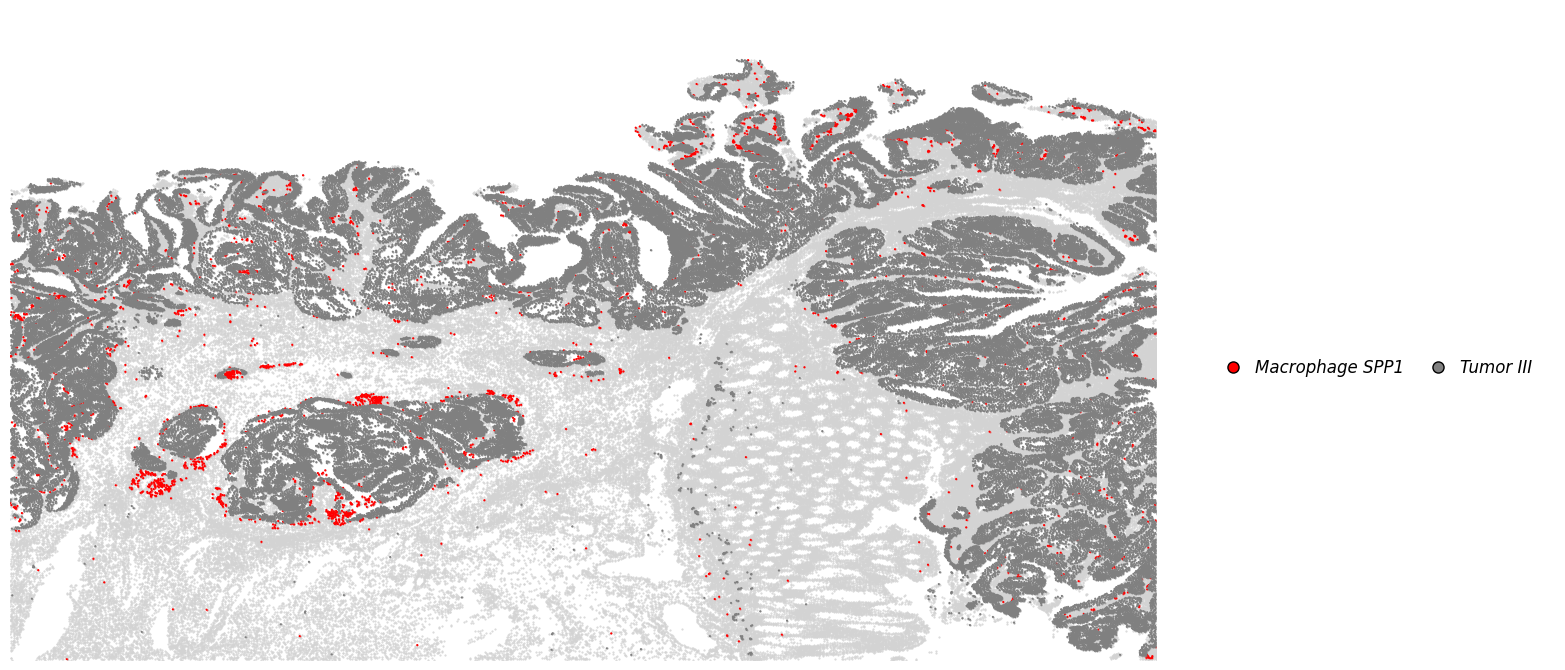

In [42]:
mapping_dict = {
    "Macrophage SPP1": "#FF0000",
    "Tumor_III all": "grey",
}

plot_dict_1 = plot_specific_celltype_gene(adata_svt, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

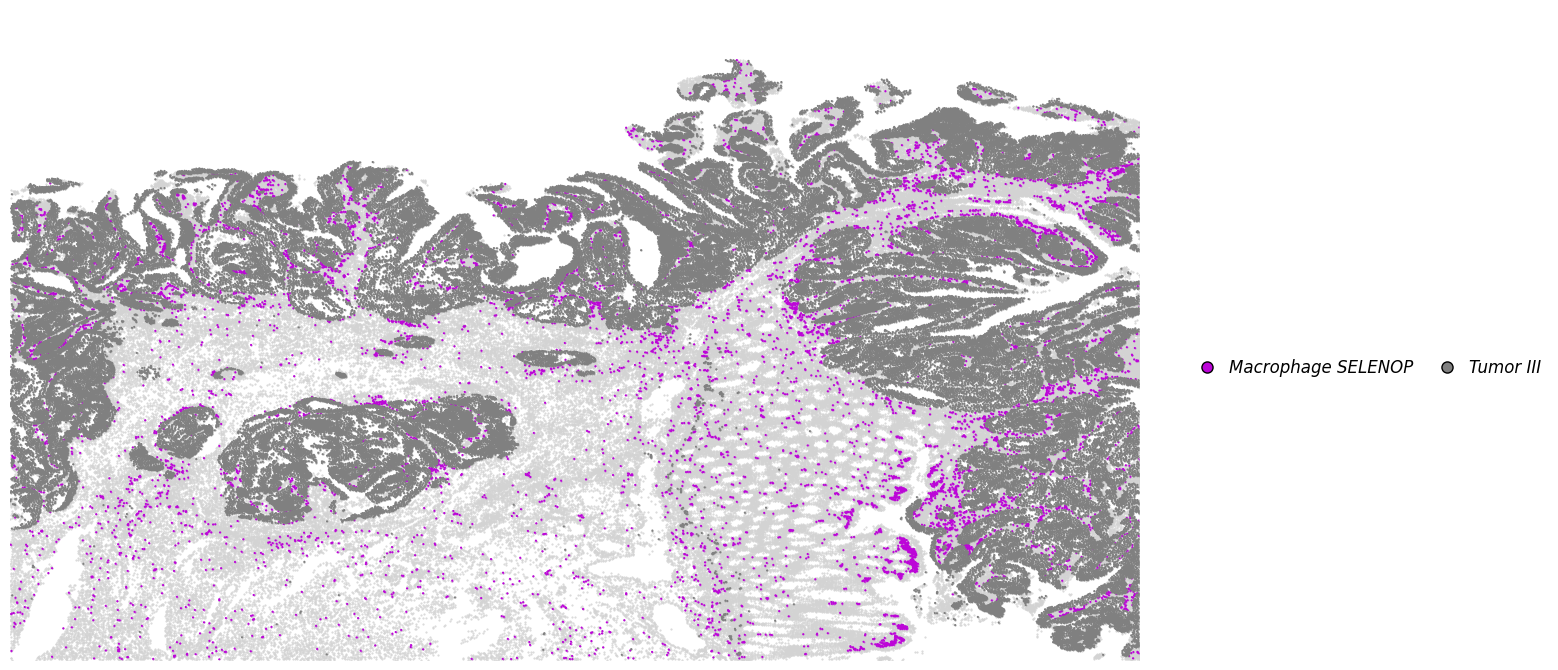

In [43]:
mapping_dict = {
    "Macrophage SELENOP": "#BC05D8",
    "Tumor_III all": "grey",
}

plot_dict_2 = plot_specific_celltype_gene(adata_svt, mapping_dict, x_col = "x", y_col = "y", s = 0.5, revert_y = False, revert_x= False)

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


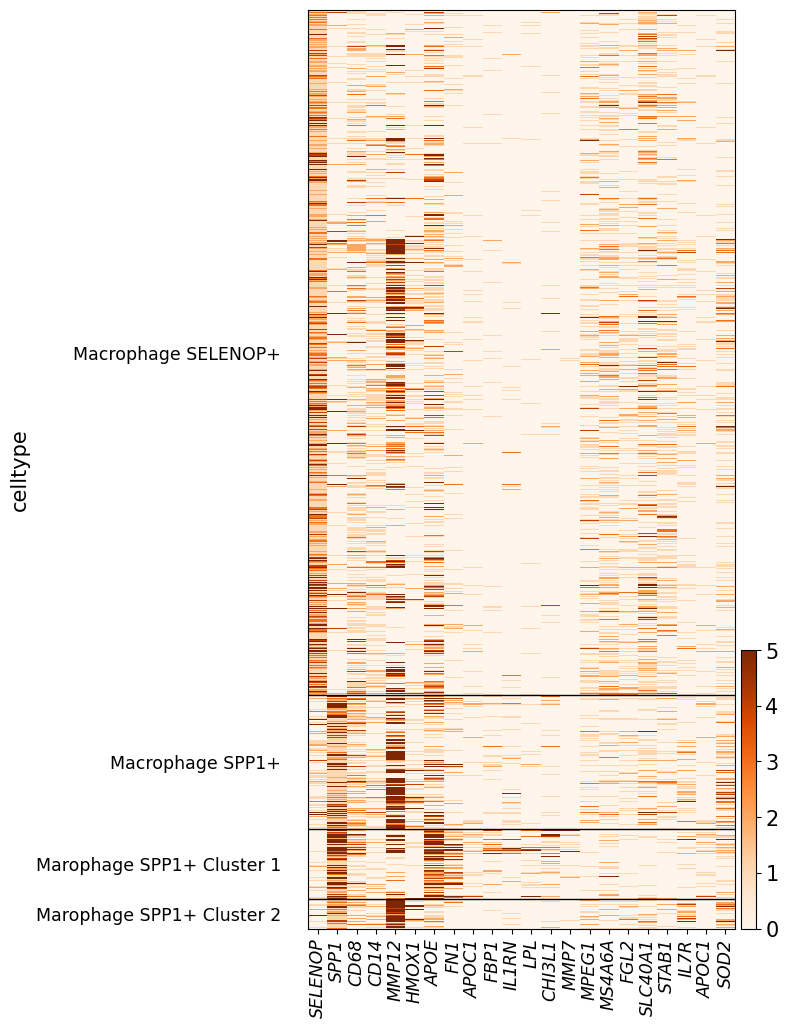

In [44]:
adata_spp1 = plot_dict_1["Macrophage SPP1"].copy()
adata_spp1.obs["celltype"] = "Macrophage SPP1+"

c1 = adata_spp1[(adata_spp1.obs["x"] > 500) & (adata_spp1.obs["x"] < 1500) & (adata_spp1.obs["y"] < 1500) & (adata_spp1.obs["y"] > 300)].obs_names # .loc[:, "celltype"]= "Marophage SPP1+ Cluster 1"
c2 = adata_spp1[(adata_spp1.obs["x"] > 2400) & (adata_spp1.obs["x"] < 3500) & (adata_spp1.obs["y"] < 2500) & (adata_spp1.obs["y"] > 1500)].obs_names
adata_spp1.obs.loc[c1, "celltype"] = "Marophage SPP1+ Cluster 1"
adata_spp1.obs.loc[c2, "celltype"] = "Marophage SPP1+ Cluster 2"

adata_selenop = plot_dict_2["Macrophage SELENOP"].copy()
adata_selenop.obs["celltype"] = "Macrophage SELENOP+"



temp = anndata.concat([adata_spp1, adata_selenop])

selected_gene = [
    "SELENOP", "SPP1", "CD68", "CD14", "MMP12", "HMOX1", "APOE", "FN1",  "APOC1", "FBP1", "IL1RN", "LPL", "CHI3L1", "MMP7", 
    "MPEG1", "MS4A6A", "FGL2", "SLC40A1", "STAB1", "IL7R", "APOC1", "SOD2"
]

gene_list = selected_gene
# As type categorical
temp.obs['celltype'] = temp.obs['celltype'].astype('category')
# All set to white
temp.uns["celltype_colors"] = ["#FFFFFF"] * len(np.unique(adata_plot.obs['celltype']))

# Only show invasive tumor and Prolif Invasive Tumor
with plt.rc_context({'font.size': 15}):
    hm = sc.pl.heatmap(temp, gene_list, groupby='celltype', cmap='Oranges', show_gene_labels=True, vmax=5, swap_axes=False, figsize=(6,12), show=False)
    # Delete groupby_ax
    ax = hm['heatmap_ax']
    for l in ax.get_xticklabels():
        l.set_style("italic")

    # Show with high dpi    
    plt.show(block=True)